In [11]:
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
import pickle
from matplotlib.colors import LinearSegmentedColormap

In [12]:
import sys
sys.setrecursionlimit(10000)

In [13]:
from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 

In [21]:
import constants
import functions
import plot_settings
import getters

In [22]:
prefix,DIR,mods,hs,pf = pickle.load(open('parsed.data','rb'))

<ipython-input-36-24b23a40c964>:24: RuntimeWarning: divide by zero encountered in log10
  cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))
<ipython-input-36-24b23a40c964>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))


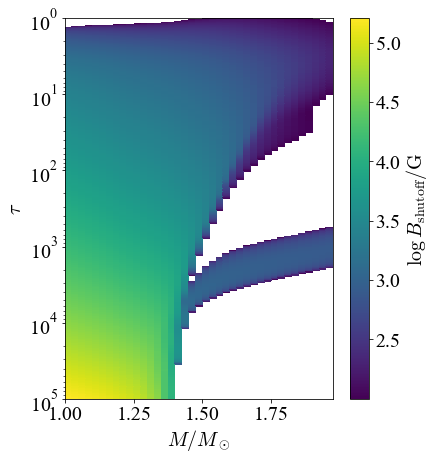

In [36]:
N = 1000
#r_grid = 1 - 10**np.linspace(-5,0,num=nR,endpoint=True)
tau_grid = 10**np.linspace(0,5,num=N,endpoint=True)

mS = []

B = []

for m,p in zip(*(mods,pf)):
	if m < 1.0 or m > 2.0:
		continue

	mS.append(m)

	tau = np.array(p.tau)

	B.append(np.interp(tau_grid, tau, p.B_shutoff))

B = np.array(B).T
B[B < 1e2] = 0

fig = plt.figure()
ax = plt.subplot(111)
cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))
cbar = fig.colorbar(cntr, ax=ax)
cbar.ax.set_ylabel(r'$\log\, B_{\rm shutoff}/\mathrm{G}$')
plt.xlabel(r'$M/M_\odot$')
plt.ylabel(r'$\tau$')
plt.yscale('log')
plt.ylim([1e5,1])
plt.savefig('../figures/m_tau_2.png')


In [37]:
pickle.load(open('parsed.data','rb'))

['/Users/ajermyn/Dropbox/Active_Projects/LowMassMagnetic/output/runs/',
 '/Users/ajermyn/Dropbox/Active_Projects/LowMassMagnetic/output/runs/magnetic_low_mass_Z_MW_profiles_time_2022_03_08_14_44_28_sha_f557/runs/',
 [1.0,
  1.025,
  1.05,
  1.075,
  1.1,
  1.125,
  1.15,
  1.175,
  1.2,
  1.225,
  1.25,
  1.275,
  1.3,
  1.325,
  1.35,
  1.375,
  1.4,
  1.425,
  1.45,
  1.475,
  1.5,
  1.525,
  1.55,
  1.575,
  1.6,
  1.625,
  1.65,
  1.675,
  1.7,
  1.725,
  1.75,
  1.775,
  1.8,
  1.825,
  1.85,
  1.875,
  1.9,
  1.925,
  1.95,
  1.975],

Envelope logBshutoff


/Users/mcantiello/Downloads/LowMassMagnetic/code/getters.py:18: RuntimeWarning: invalid value encountered in log10
  return log10(g(h,CZ,'B_shutoff'))
<ipython-input-24-6e253cf6c69b>:106: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)


OSError: /Users/ajermyn/Dropbox/Active_Projects/LowMassMagnetic/output/runs/magnetic_low_mass_Z_MW_profiles_time_2022_03_08_14_44_28_sha_f557/runs/1.1/LOGS/history.data not found.

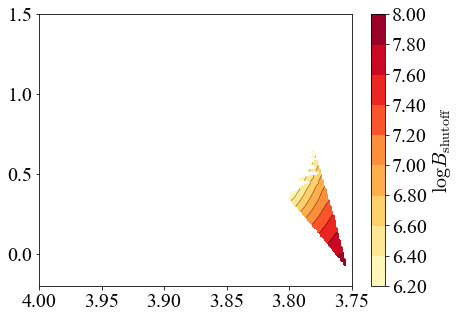

In [24]:
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
import pickle

from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 
 
from constants import *
from plot_settings import *
from functions import *
from getters import *
from star_data import stars

prefix,DIR,mods,hs,_ = pickle.load(open('parsed.data','rb'))

# Data Location
FIGURES='../figures/' # Place to save plots

# STRINGS
logteff=r'$\log_{10}\, T_{\rm eff}$/K'
logell=r'$\log_{10}\, L$/L$_\odot$'

# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def tri_area(xs,ys):
  arr = np.ones((3,3))
  arr[0] = xs
  arr[1] = ys
  area = 0.5 * np.linalg.det(arr)
  return area

def read_models(location,lis,hrd, CZ, getter, name, bar_label, xlim,ylim,dt,dl,cmap, extra_label):
    # Load the data
    x = []
    y = []
    z = []

    for i,j in enumerate(lis):
      h=hs[i]
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh = h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      x.append(logt[zams:])
      y.append(logl[zams:])
      z.append(getter(CZ,h)[zams:])

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    # Filter triangles by area and length to avoid high aspect ratio/super narrow ones/giant ones.
    triang = tri.Triangulation(x,y)
    areas = np.array(list(tri_area(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    max_lengths = np.array(list(tri_max_length(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    triang.set_mask((areas > 0.006) | (max_lengths > 0.8))

    # Interpolate onto a grid
    numcols, numrows = 200,200
    xi = np.linspace(min(xlim),max(xlim),numcols)
    yi = np.linspace(min(ylim),max(ylim),numcols)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # Clip to 1st-99th percentile to avoid extremes at the edges.
    sel = np.isfinite(zi)
    maxval = np.percentile(zi[sel], 99)
    minval = np.percentile(zi[sel], 1)
    zi[zi > maxval] = maxval
    zi[zi < minval] = minval

    # Set up figure
    fig = plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    plt.gca().invert_xaxis()    

    # Use fewer contours when the data have a small range or that are noisy.
    # Everything is log-scales, so 1 is actually a characteristic scale here.
    levels = 8
    if maxval - minval < 1:
      levels = 4
    elif maxval - minval < 0.3:
      levels = 3
    elif name == 'logTurnover':
      levels = 6
    elif name == 'logSbot' or name == 'logStop':
      levels = 6

    # Plot contours
    ax.contour(xi, yi, zi, levels, colors='k', linewidths=0.3)    
    cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
    cbar = fig.colorbar(cntr1, ax=ax)
    cbar.ax.set_ylabel(bar_label)
    ls = list(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in ls])

    for j in hrd:
      h=mr.MesaData(DIR+str(j)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      ax.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
      ax.text(logt[zams]+dt,logl[zams]+dl,str(j)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
                

    # Plot stars
    ax.scatter(stars[:,0], stars[:,1], c='k')

    # Format plot
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)

    ax.text(max(xlim)-0.02*(max(xlim)-min(xlim)),min(ylim)+0.03*(max(ylim)-min(ylim)),CZ,ha='left',fontsize=16)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)   

    ax2 = ax.twiny()

    # Bounds of spectral types
    tick_locs = np.log10((1e5,3e4,1e4,7500,6100,5300,3800,2650))
    tick_labels = list('' for _ in tick_locs)

    ind_first = 0
    for i in range(len(tick_locs)):
      if tick_locs[i] < max(xlim):
        ind_first = i
        break

    ind_last = len(tick_locs)
    for i in range(len(tick_locs)-1,0,-1):
      if tick_locs[i] > min(xlim):
        ind_last = i+1
        break

    ax2.set_xticks(tick_locs[ind_first:ind_last])
    ax2.set_xticklabels(tick_labels[ind_first:ind_last])

    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim) # This has to come later, otherwise matplotlib expands the xlims to accomoddate the new ticks.

    # Spectral type labels
    locs = 0.5 * (tick_locs[1:] + tick_locs[:-1])
    labels = ('O','B','A','F','G','K','M')
    for loc,lab in zip(*(locs,labels)):
      if loc > min(xlim) and loc < max(xlim):
        ax.text(loc,max(ylim)+0.03*(max(ylim)-min(ylim)),lab)

    plt.savefig(FIGURES+CZ+'_'+name+'.pdf',bbox_inches='tight')

# Plot the CZ-dependent quantities

CZs = [
  ('Envelope',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HI',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HeII',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

plots = [
  (logB_shutoff, 'logBshutoff', r'$\log B_{\rm shutoff}$','YlOrRd')
]

for getter,name,label,cmap in plots:
  for CZ,xlim,ylim,hrd,dt,dl in CZs:
    print(CZ,name)
    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)

# Now plot the one-off's

CZs = [
  ('All',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

plots = [
  (logB_shutoff_tau_3, 'logB_shutoff_tau_3', r'$\log B_{\rm shutoff}(\tau=3)$','YlGnBu'),
  (logB_shutoff_tau_10, 'logB_shutoff_tau_10', r'$\log B_{\rm shutoff}(\tau=10)$','YlGnBu'),
  (logB_shutoff_tau_100, 'logB_shutoff_tau_100', r'$\log B_{\rm shutoff}(\tau=100)$','YlGnBu')
]

for getter,name,label,cmap in plots:
  for CZ,xlim,ylim,hrd,dt,dl in CZs:
    print(CZ,name)
    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)

